In [ ]:
import json
import pandas as pd
import re
from datetime import datetime
import requests

In [94]:
# получение списка городов с id

response_json = requests.get(
    "https://api.hh.ru/areas", headers={"User-Agent": "Mozilla/5.0"}).json()

areas = []
for i in response_json:
    for k in i['areas']:
        if len(k['areas']) != 0:
            for j in k['areas']:
                areas.append({"country_id": i['id'],
                              "country": i['name'],
                              "city_id": j['id'],
                              "city": j['name']})
        else:
            areas.append({"country_id": i['id'],
                          "country": i['name'],
                          "city_id": k['id'],
                          "city": k['name']})


areas = pd.DataFrame(areas)
areas.head(3)

,country_id,country,city_id,city
0,113,Россия,4228,Виловатово
1,113,Россия,1621,Волжск
2,113,Россия,1622,Звенигово


In [171]:
areas.query('city.str.contains("Москв")')

,country_id,country,city_id,city
2083,113,Россия,1,Москва


---

In [3]:
# получение списка специализаций с id

response_json = requests.get(
    "https://api.hh.ru/professional_roles", headers={"User-Agent": "Mozilla/5.0"}).json()

df_professions = []
for i in response_json["categories"]:
    for k in i["roles"]:
        df_professions.append(
            {"category": i["name"],
             "id": k["id"],
             "name": k["name"]})

df_professions = pd.DataFrame(df_professions)
df_professions.head(3)

,category,id,name
0,Автомобильный бизнес,4,Автомойщик
1,Автомобильный бизнес,5,"Автослесарь, автомеханик"
2,Автомобильный бизнес,62,Мастер-приемщик


In [17]:
# выгрузка в Excel
df_professions.to_excel('hh_professions_' + str(datetime.now().strftime('%Y-%m-%d')) + '.xlsx', engine='xlsxwriter',
                        sheet_name='Sheet1', na_rep='', columns=None, header=True, index=False, index_label=None, merge_cells=False)

---

### Скрипт формирует 2 файла в Excel:
1. таблица с актуальными вакансиями по выбранным специализациям - 'hh_vacancies_yyyy-mm-dd.xlsx'.
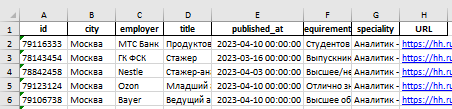


2. список упоминаемых в вакансиях навыков с частотой встречаемости, от наиболее частых к менее - 'hh_requirements_yyyy-mm-dd.xlsx'.
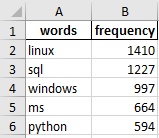




При указании параметров пагинации (page, per_page) работает ограничение: глубина возвращаемых результатов не может быть больше 2000. Например, возможен запрос per_page=10&page=199 (выдача с 1991 по 2000 вакансию), но запрос с per_page=10&page=200 вернёт ошибку (выдача с 2001 по 2010 вакансию)

    id	name

- 10	Аналитик
- 112	Сетевой инженер
- 113	Системный администратор
- 114	Системный инженер
- 116	Специалист по информационной безопасности
- 121	Специалист технической поддержки
- 124	Тестировщик
- 148	Системный аналитик
- 150	Бизнес-аналитик
- 156	BI-аналитик, аналитик данных
- 157	Руководитель отдела аналитики
- 160	DevOps-инженер
- 164	Продуктовый аналитик
- 165	Дата-сайентист

In [30]:
#%%time
#CPU times: total: 8.19 s
#Wall time: 3min 20s



# список профессий, по которым будут выгружены вакансии
it_professions = [10, 112, 113, 114, 116, 121, 124,
                  148, 150, 156, 157, 160, 164, 165]

# Функция запроса к API HH
def vacancies_request(parameters):
    vacancies_json = requests.get("https://api.hh.ru/vacancies",
                                  headers={"User-Agent": "Mozilla/5.0"}, params=parameters).json()
    req_result = []
    for i in vacancies_json["items"]:
        speciality = ""
        for k in i["professional_roles"]:
            speciality = speciality + k['name'] + " - " + k['id']
        req_result.append({
            "id": i["id"],
            "city": i["area"]["name"],
            "employer": i["employer"]["name"],
            "title": i["name"],
            "published_at": i["published_at"][:10],
            "requirements": i["snippet"]["requirement"],
            "speciality": speciality,
            "URL": i["alternate_url"]
        })
    return req_result


# цикл выгрузки вакансии по одной профессии из списка, с подциклом для выгрузки по 100 штук. Больше 100 за запрос нельзя.
vacancies_total = []
for k in range(0, len(it_professions)):
    for i in range(0, 20):
        params = {
            "professional_role": it_professions[k],
            "area": 1,
            "page": i,
            "per_page": 100  # максимум 100
        }
        vacancies_total.extend(vacancies_request(params))


# полученный в цикле список передаем в датафрейм, убираем лишнее. Выгружаем в Excel.
df_vacancies = pd.DataFrame(vacancies_total)\
                 .drop_duplicates(subset='id')\
                 .dropna(subset='requirements')\
                 .reset_index(drop=True)
df_vacancies.published_at = pd.to_datetime(df_vacancies.published_at)

df_vacancies.to_excel('hh_vacancies_' + str(datetime.now().strftime('%Y-%m-%d')) + '.xlsx',
                      engine='xlsxwriter', index=False)


# все слова из блоков с требованиями добавляем в отдельный список
requirements_words = []
[requirements_words.extend(re.split('\W+', i)) for i in df_vacancies.requirements]

# полученный список преобразуем в Series, убираем все числа, а также слова, содержацие символы из list_for_removing
df_requirements = pd.Series(requirements_words).str.lower()
df_requirements = [i for i in df_requirements if not all(k.isdigit() for k in i)]

list_for_removing = ['a', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к',
                     'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ы', 'ч',
                     'я', 'х', 'microsoft', 'it']
df_requirements = [i for i in df_requirements if not any(k in i for k in list_for_removing)]

# делаем датафрейм, корректируем, аггрегируем данные с частотой и выгружаем в Excel.
df_requirements = pd.DataFrame(df_requirements)\
                    .rename(columns={0: 'words'})\
                    .query("words != ''")\
                    .reset_index(drop=True)
df_requirements['frequency'] = 1
df_requirements = df_requirements.groupby('words', as_index=False)\
                                 .agg({'frequency': 'count'})\
                                 .sort_values('frequency', ascending=False)

df_requirements.to_excel('hh_requirements_top_' + str(datetime.now().strftime('%Y-%m-%d')) + '.xlsx',
                         engine='xlsxwriter', index=False)

CPU times: total: 8.67 s
Wall time: 3min 11s
